Title: ECE Computer Vision Project 1 report

Author: Yiming Wang

Email: ywang225@ncsu.edu

In [5]:
import os
import matplotlib.image as mpimg 
import numpy as np
import matplotlib.pyplot as plt
import random

Read Train images

In [6]:
os.getcwd()
#os.chdir("Documents/ncsu course/ncsu 2019 spring/ECE/Project 1")
resolution=10

Train_images=os.listdir("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Train")
#print(len(Train_images))
#print(len(os.listdir("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Train")))#2000 images

Face_Train_images=[name for name in Train_images if name.startswith("face_")==True]
Nonface_Train_images=[name for name in Train_images if name.startswith("nonface_")==True]

Face_Train_images_arr=np.zeros((1000,resolution,resolution,3))
for i in range(1000):# 3 doesn'r work
    rbg_arr=mpimg.imread("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Train/"+Face_Train_images[i])
    if rbg_arr.shape!=(resolution,resolution,3):
        print("False")
    Face_Train_images_arr[i,:,:,:]=rbg_arr
    
Nonface_Train_images_arr=np.zeros((1000,resolution,resolution,3))
for i in range(1000):
    rbg_arr=mpimg.imread("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Train/"+Nonface_Train_images[i])
    if rbg_arr.shape!=(resolution,resolution,3):
        print("False")
    Nonface_Train_images_arr[i,:,:,:]=rbg_arr
   
Face_Train_images=Face_Train_images_arr.reshape((1000,resolution*resolution*3))
Nonface_Train_images=Nonface_Train_images_arr.reshape((1000,resolution*resolution*3))
Train_images=np.zeros((2000,resolution*resolution*3))
Train_images[0:1000,]=Face_Train_images
Train_images[1000:2000,]=Nonface_Train_images

Read Test Face images and Nonface images into array

In [7]:
Test_images=os.listdir("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Test")
#print(len(Test_images))
#print(len(os.listdir("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Test")))#2000 images

Face_Test_images=[name for name in Test_images if name.startswith("face_")==True]
Nonface_Test_images=[name for name in Test_images if name.startswith("nonface_")==True]

#print(len(Face_Test_images))
#print(len(Nonface_Test_images))

Face_Test_images_arr=np.zeros((100,resolution,resolution,3))
for i in range(100):
    rbg_arr=mpimg.imread("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Test/"+Face_Test_images[i])
    if rbg_arr.shape!=(resolution,resolution,3):
        print("False")
    Face_Test_images_arr[i,:,:,:]=rbg_arr
    
    
Nonface_Test_images_arr=np.zeros((100,resolution,resolution,3))
for i in range(100):
    rbg_arr=mpimg.imread("resolution"+str(resolution)+"by"+str(resolution)+"/extracted_pics/Test/"+Nonface_Test_images[i])
    if rbg_arr.shape!=(resolution,resolution,3):
        print("False")
    Nonface_Test_images_arr[i,:,:,:]=rbg_arr
   
Face_Test_images = Face_Test_images_arr.reshape((100,resolution*resolution*3))
Nonface_Test_images = Nonface_Test_images_arr.reshape((100,resolution*resolution*3))
Test_images = np.zeros((200,resolution*resolution*3))
Test_images[0:100,] = Face_Test_images
Test_images[100:200,] = Nonface_Test_images

Model 1: Single Gaussian

[0.001  0.01   0.0055]
[0.31 0.01 0.16]


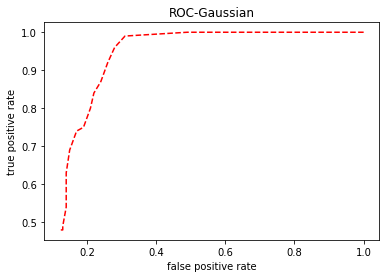

Text(0.5, 1.0, 'cov-NonFace')

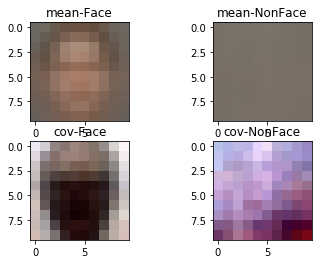

In [8]:
import os
import matplotlib.image as mpimg 
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np


def EM_Gaussian(Input_data):
    trans=Input_data
    mu=np.mean(trans,axis=0)
    sigma=np.cov(trans.transpose())
    return([mu,sigma])


def Log_p_Gaussian(Input_data_orig,Face=True):
    if(Face==True):#for Face
        [mu,sigma]=EM_Gaussian(Face_Train_images)
    else:#for Nonface
        [mu,sigma]=EM_Gaussian(Nonface_Train_images)
    temp_center=Input_data_orig-mu
    log_p=np.sum(np.log(np.linalg.svd(sigma)[1]))*(-1/2)-(1/2)*np.sum(np.multiply(np.dot(temp_center,np.linalg.pinv(sigma)),temp_center),axis=1)
    return(log_p)


def Label_Gaussian(Input_data,threshold=0.5):
    delta=Log_p_Gaussian(Input_data,Face=True)-Log_p_Gaussian(Input_data,Face=False)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):
        estimated_label=np.zeros(Input_data.shape[0])
        estimated_label[[i for i in range(Input_data.shape[0]) if delta[i]>ratio_threshold]]=1
    return(estimated_label)
    

def FR_Gaussian(Input_data,true_label,threshold=0.5):
    N=Input_data.shape[0]
    delta=Log_p_Gaussian(Input_data,Face=True)-Log_p_Gaussian(Input_data,Face=False)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):#threshold is a scalar
        #face_or_nonface
        estimated_label=np.zeros(N)
        estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
        #False Rate
        FR=np.zeros(3)
        FR[0]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
        FR[1]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        FR[2]=np.mean(np.abs(estimated_label-true_label))
        return(FR)
                

def ROC_Gaussian(Input_data,true_label,ratio_threshold_seq):
    N=Input_data.shape[0]
    delta=Log_p_Gaussian(Input_data,Face=True)-Log_p_Gaussian(Input_data,Face=False)#log_p_face-log_p_nonface
    if(isinstance(ratio_threshold_seq,np.ndarray)):#threshold is a seq
        FR=np.zeros((2,len(ratio_threshold_seq)))#false positive rate and false negative rate
        for i in range(len(ratio_threshold_seq)):
            #face_or_nonface
            ratio_threshold=ratio_threshold_seq[i]
            estimated_label=np.zeros(N)
            estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
            #False Rate
            FR[0,i]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
            FR[1,i]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        plt.plot(FR[0,:],1-FR[1,:],"r--")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")
        plt.title("ROC-Gaussian")
        plt.show()
 
#Evaluate the learned model on the testing images
Test_true_label=np.zeros(200)
Test_true_label[0:100]=1 
Train_true_label=np.zeros(2000)  
Train_true_label[0:1000]=1 

#EM_Gaussian(Face_Train_trans)
print(FR_Gaussian(Train_images,true_label=Train_true_label,threshold=0.5))
print(FR_Gaussian(Test_images,true_label=Test_true_label,threshold=0.5))
ROC_Gaussian(Test_images,true_label=Test_true_label,ratio_threshold_seq=np.arange(-1500,1500,100))


plt.subplot(2, 2, 1)
#mean
[Face_mu,Face_sigma]=EM_Gaussian(Face_Train_images)
plt.imshow(Face_mu.reshape((10,10,3)).astype(int))
plt.title("mean-Face")
plt.subplot(2, 2, 2)
[Nonface_mu,Nonface_sigma]=EM_Gaussian(Nonface_Train_images)
plt.imshow(Nonface_mu.reshape((10,10,3)).astype(int))
plt.title("mean-NonFace")

plt.subplot(2, 2, 3)
#cov
cov_diag=np.diag(Face_sigma)
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-Face")

plt.subplot(2, 2, 4)
cov_diag=np.diag(Nonface_sigma)
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-NonFace")


Model 2: Mixture of Gaussian

In [9]:
def EM_Mix_Gaussian(Input_data,K=3): 
    trans=Input_data
    (N,D)=trans.shape
    #start of u and sigma and h
    h_start=np.ones(K)*(1/K)
    u_start=np.ones((K,D))
    sigma_start=np.ones((K,D,D))
    a=list(range(N))
    random.shuffle(a)
    group_size=int(N/K)
    for i in range(K):
        u_start[i,:]=np.mean(trans[a[(group_size*i):(group_size*(i+1))],:],axis=0)
        sigma_start[i,:,:]=np.diag(np.diag(np.cov(trans[a[(group_size*i):(group_size*(i+1))],].transpose())))#D*D
    h_next=np.zeros(K)
    u_next=np.zeros((K,D))
    sigma_next=np.zeros((K,D,D))
    h_current=h_start
    u_current=u_start
    sigma_current=sigma_start
    
    log_x_gaussian=np.ones((N,K))
    S=np.ones((N,K))
    #EM
    for t in range(30):
        #E-step  
        for k in range(K):
            temp_center=trans-u_current[k,:]
            log_x_gaussian[:,k]=-(1/2)*np.sum(np.multiply(np.dot(temp_center,np.linalg.pinv(sigma_current[k,:,:])),temp_center),axis=1)-\
            (1/2)*np.sum(np.log(np.linalg.svd(sigma_current[k,:,:])[1]))
        for k in range(K):
            for n in range(N):
                S[n,k]=h_current[k]/np.sum(h_current*np.exp(log_x_gaussian[n,:]-log_x_gaussian[n,k]))  
        #M-step
        #update u
        u_next=(np.dot(S.transpose(),trans).transpose()/np.sum(S,axis=0)).transpose()#K*D
        #update sigma
        for k in range(K):
           temp_center=trans-u_next[k,:]
           sigma_next[k,:,:]=np.dot(np.multiply(temp_center.transpose(),S[:,k]),temp_center)/np.sum(S[:,k])
           sigma_next[k,:,:]-sigma_current[k,:,:]
        #update h  
        h_next=np.sum(S,axis=0)/np.sum(S)
        
        #check convergence
        delta_u=np.linalg.norm(u_next-u_current)/np.linalg.norm(u_current)
        delta_h=np.linalg.norm(h_next-h_current)/np.linalg.norm(h_current)
        delta_sigma=np.linalg.norm(sigma_next-sigma_current)/np.linalg.norm(sigma_current)
        #print(np.linalg.norm(u_next-u_current))
        #print(delta_u)
        #print(delta_h)
        #print(delta_sigma)
      
        u_current=u_next
        h_current=h_next
        for k in range(K):
           sigma_current[k,:,:]=np.diag(np.diag(sigma_next[k,:,:]))
        
    sigma=sigma_current
    h=h_current
    u=u_current
    return([sigma,h,u])


def Label_Mix_Gaussian(Input_data_orig,K,threshold=0.5):
    N=Input_data_orig.shape[0]
    (Face_sigma,Face_h,Face_u)=EM_Mix_Gaussian(Face_Train_images,K=K)   
    (Nonface_sigma,Nonface_h,Nonface_u)=EM_Mix_Gaussian(Nonface_Train_images,K=K) 
    Face_trans=Input_data_orig#N*D
    Nonface_trans=Input_data_orig
    
    #(x-u)Sigma^(-1)(x-u)
    temp_face=np.zeros((Input_data_orig.shape[0],K))#N*K
    temp_nonface=np.zeros((Input_data_orig.shape[0],K))
    for i in range(K):
        temp_face[:,i]=np.sum(np.multiply(np.dot(Face_trans-Face_u[i,:],np.linalg.pinv(Face_sigma[i,:,:])),Face_trans-Face_u[i,:]),axis=1)
        temp_nonface[:,i]=np.sum(np.multiply(np.dot(Nonface_trans-Nonface_u[i,:],np.linalg.pinv(Nonface_sigma[i,:,:])),Nonface_trans-Nonface_u[i,:]),axis=1)   
    log_det_face=np.zeros(K)
    log_det_nonface=np.zeros(K)
    for i in range(K):
        log_det_face[i]=np.sum(np.log(np.linalg.svd(Face_sigma[i,:,:])[1]))
        log_det_nonface[i]=np.sum(np.log(np.linalg.svd(Nonface_sigma[i,:,:])[1])) 
     
    estimated_label=np.ones(Input_data_orig.shape[0])*2
    
    #no numerical problems
    if(False):
        p_ratio_face_non=np.zeros(Input_data_orig.shape[0])
        for n in range(Input_data_orig.shape[0]):
            #n=0
            temp_p=np.zeros(K)
            for j in range(K):    
                temp_p[j]=np.sum(np.exp(-(1/2)*(log_det_nonface-log_det_face[j])-(1/2)*(temp_nonface[n,:]-temp_face[n,j])+np.log(Nonface_h)-np.log(Face_h[j])))
            #print(temp_p)
            p_ratio_face_non[n]=np.sum(1.0/temp_p)

        
        p_ratio_non_face=np.zeros(Input_data_orig.shape[0])
        for n in range(Input_data_orig.shape[0]):
            #n=0
            temp_p=np.zeros(K)
            for j in range(K):
                temp_p[j]=np.sum(np.exp(-(1/2)*(log_det_face-log_det_nonface[j])-(1/2)*(temp_face[n,:]-temp_nonface[n,j])*(Face_h/Nonface_h[j])))
            p_ratio_non_face[n]=np.sum(1.0/temp_p)
           
        p_ratio_non_face
        p_ratio_face_non
        useful_index=[i for i in range(Input_data_orig.shape[0]) if p_ratio_non_face[i]!=p_ratio_face_non[i]]
        no_useful_index=[i for i in range(Input_data_orig.shape[0]) if p_ratio_non_face[i]==p_ratio_face_non[i]]
        estimated_label[[i for i in useful_index if p_ratio_non_face[i]!=p_ratio_face_non[i] and p_ratio_face_non[i]>((1-threshold)/threshold)]]=1
        estimated_label[[i for i in useful_index if p_ratio_non_face[i]!=p_ratio_face_non[i] and p_ratio_face_non[i]<=((1-threshold)/threshold)]]=0
        
    #numerical problem exists
    log_p_ratio_face_non=np.zeros(Input_data_orig.shape[0])
    for n in range(Input_data_orig.shape[0]):
        temp_p=np.zeros(K)
        for j in range(K): 
            temp_p[j]=np.max(-(1/2)*(log_det_nonface-log_det_face[j])-(1/2)*(temp_nonface[n,:]-\
                  temp_face[n,j])+np.log(Nonface_h)-np.log(Face_h[j]))
        log_p_ratio_face_non[n]=-np.min(temp_p)
    log_p_ratio_non_face=np.zeros(Input_data_orig.shape[0])
    for n in range(Input_data_orig.shape[0]):
        temp_p=np.zeros(K)
        for j in range(K):
            temp_p[j]=np.max(-(1/2)*(log_det_face-log_det_nonface[j])-(1/2)*(temp_face[n,:]-\
                  temp_nonface[n,j])+np.log(Face_h)-np.log(Nonface_h[j]))
        log_p_ratio_non_face[n]=-np.min(temp_p)

    
    estimated_label[[i for i in range(N) if log_p_ratio_face_non[i]>-np.log(threshold/(1-threshold))]]=1
    estimated_label[[i for i in range(N) if log_p_ratio_face_non[i]<=-np.log(threshold/(1-threshold))]]=0

    return(estimated_label)
    
  
    
def FR_Mix_Gaussian(Input_data_orig,true_label,K=3,threshold=0.5):
    N=Input_data_orig.shape[0]
    estimated_label=Label_Mix_Gaussian(Input_data_orig,K=K,threshold=threshold)
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):#threshold is a scalar      
        FR=np.zeros(3)
        FR[0]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
        FR[1]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        FR[2]=np.mean(np.abs(estimated_label-true_label))
        return(FR)
    

    
def ROC_Mix_Gaussian(Input_data_orig,true_label,ratio_threshold_seq,K=3):
    N=Input_data_orig.shape[0]
    (Face_sigma,Face_h,Face_u)=EM_Mix_Gaussian(Face_Train_images,K=K)   
    (Nonface_sigma,Nonface_h,Nonface_u)=EM_Mix_Gaussian(Nonface_Train_images,K=K) 
    Face_trans=Input_data_orig
    Nonface_trans=Input_data_orig  
    #(x-u)Sigma^(-1)(x-u)
    temp_face=np.zeros((Input_data_orig.shape[0],K))#N*K
    temp_nonface=np.zeros((Input_data_orig.shape[0],K))
    for i in range(K):
        temp_face[:,i]=np.sum(np.multiply(np.dot(Face_trans-Face_u[i,:],np.linalg.pinv(Face_sigma[i,:,:])),Face_trans-Face_u[i,:]),axis=1)
        temp_nonface[:,i]=np.sum(np.multiply(np.dot(Nonface_trans-Nonface_u[i,:],np.linalg.pinv(Nonface_sigma[i,:,:])),Nonface_trans-Nonface_u[i,:]),axis=1)   

    log_det_face=np.zeros(K)
    log_det_nonface=np.zeros(K)
    for i in range(K):
        log_det_face[i]=np.sum(np.log(np.linalg.svd(Face_sigma[i,:,:])[1]))
        log_det_nonface[i]=np.sum(np.log(np.linalg.svd(Nonface_sigma[i,:,:])[1])) 
    if(False):
        #no numerical problems
        p_ratio_face_non=np.zeros(Input_data_orig.shape[0])
        for n in range(Input_data_orig.shape[0]):
            temp_p=np.zeros(K)
            for j in range(K):    
                temp_p[j]=np.sum(np.exp(-(1/2)*(log_det_nonface-log_det_face[j])-(1/2)*(temp_nonface[n,:]-temp_face[n,j])+np.log(Nonface_h)-np.log(Face_h[j])))

            p_ratio_face_non[n]=1/np.sum(temp_p)        
        p_ratio_non_face=np.zeros(Input_data_orig.shape[0])
        for n in range(Input_data_orig.shape[0]):
            #n=0
            temp_p=np.zeros(K)
            for j in range(K):
                temp_p[j]=np.sum(np.exp(-(1/2)*(log_det_face-log_det_nonface[j])-(1/2)*(temp_face[n,:]-temp_nonface[n,j])*(Face_h/Nonface_h[j])))
            p_ratio_non_face[n]=1/np.sum(temp_p)
          
     #numerical problem exists
    log_p_ratio_face_non=np.zeros(Input_data_orig.shape[0])
    for n in range(Input_data_orig.shape[0]):
        temp_p=np.zeros(K)
        for j in range(K): 
            #j=0
            temp_p[j]=np.max(-(1/2)*(log_det_nonface-log_det_face[j])-(1/2)*(temp_nonface[n,:]-\
                  temp_face[n,j])+np.log(Nonface_h)-np.log(Face_h[j]))
            #print(temp_p[j])
            
        #print(temp_p)
        
        log_p_ratio_face_non[n]=-np.min(temp_p)
        #print(log_p_ratio_face_non[n])
    #print(log_p_ratio_face_non)
    
    log_p_ratio_non_face=np.zeros(Input_data_orig.shape[0])
    for n in range(Input_data_orig.shape[0]):
        #n=0
        temp_p=np.zeros(K)
        for j in range(K):
            temp_p[j]=np.max(-(1/2)*(log_det_face-log_det_nonface[j])-(1/2)*(temp_face[n,:]-\
                  temp_nonface[n,j])+np.log(Face_h)-np.log(Nonface_h[j]))
        #print(temp_p)
        log_p_ratio_non_face[n]=-np.min(temp_p)
        #print(log_p_ratio_non_face[n])
    #print(log_p_ratio_non_face)
    FR=np.zeros((2,len(ratio_threshold_seq)))
    for i in range(len(ratio_threshold_seq)):
        #face_or_nonface
        ratio_threshold=ratio_threshold_seq[i]
        estimated_label=np.ones(Input_data_orig.shape[0])*2
        estimated_label[[i for i in range(Input_data_orig.shape[0]) if log_p_ratio_face_non[i]>-ratio_threshold]]=1#>-np.log(threshold/(1-threshold))
        estimated_label[[i for i in range(Input_data_orig.shape[0]) if log_p_ratio_face_non[i]<=-ratio_threshold]]=0#<=-np.log(threshold/(1-threshold)
       
        FR[0,i]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
        FR[1,i]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
    plt.plot(FR[0,:],1-FR[1,:],"r--")
    plt.show()
        

#Evaluate the learned model on the testing images
Test_true_label=np.zeros(200)
Test_true_label[0:100]=1    
Train_true_label=np.zeros(2000)
Train_true_label[0:1000]=1

for K in range(1,7):
    print(K)
    print(FR_Mix_Gaussian(Train_images,Train_true_label,K=K,threshold=0.5))
    
for K in range(1,7):
    print(K)
    print(FR_Mix_Gaussian(Test_images,Test_true_label,K=K,threshold=0.5))
  


1
[0.356  0.163  0.2595]
2
[0.3    0.135  0.2175]
3
[0.309  0.132  0.2205]
4
[0.181  0.114  0.1475]
5
[0.202  0.097  0.1495]
6
[0.184  0.091  0.1375]
1
[0.37  0.16  0.265]
2
[0.26  0.15  0.205]
3
[0.41 0.15 0.28]
4
[0.23  0.12  0.175]
5
[0.17  0.12  0.145]
6
[0.24 0.12 0.18]


Based on the false positive rate, false negative rate an misclassification rate when using 1 cluster to 6 clusters on train images, we found using 6 clusters has the smallest false rate. Therefore, we choose mixture of gaussian with 6 clusters and perform this model on test images.

[0.2   0.13  0.165]


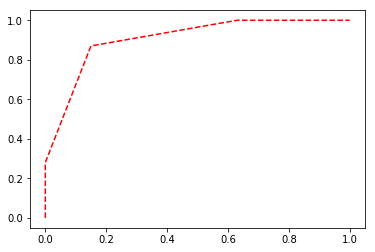

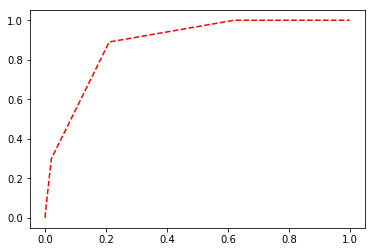

Text(0.5, 1.0, 'cov-NonFace')

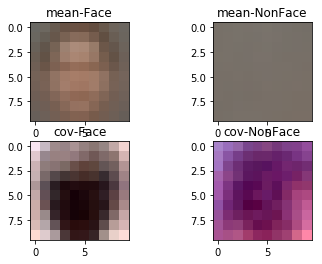

In [10]:
print(FR_Mix_Gaussian(Test_images,Test_true_label,K=6,threshold=0.5))

(Face_sigma,Face_h,Face_u)=EM_Mix_Gaussian(Face_Train_images,K=5)   
(Nonface_sigma,Nonface_h,Nonface_u)=EM_Mix_Gaussian(Nonface_Train_images,K=5) 

ROC_Mix_Gaussian(Test_images,true_label=Test_true_label,ratio_threshold_seq=np.arange(-1500,1500,100),K=5)
ROC_Mix_Gaussian(Test_images,true_label=Test_true_label,ratio_threshold_seq=np.arange(-1500,1500,100),K=5)


plt.subplot(2, 2, 1)
#mean
(Face_sigma,Face_h,Face_u)=EM_Mix_Gaussian(Face_Train_images,K=K)   
(Nonface_sigma,Nonface_h,Nonface_u)=EM_Mix_Gaussian(Nonface_Train_images,K=K) 

plt.imshow(np.dot(Face_h,Face_u).reshape((10,10,3)).astype(int))
plt.title("mean-Face")

plt.subplot(2, 2, 2)
plt.imshow(np.dot(Nonface_h,Nonface_u).reshape((10,10,3)).astype(int))
plt.title("mean-NonFace")

plt.subplot(2, 2, 3)
#cov
cov_diag=np.zeros(10*10*3)
for i in range(Face_sigma.shape[0]):
    cov_diag=cov_diag+np.diag(Face_sigma[i,:,:])*Face_h[i]
    
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-Face")

plt.subplot(2, 2, 4)
cov_diag=np.zeros(10*10*3)
for i in range(Face_sigma.shape[0]):
    cov_diag=cov_diag+np.diag(Nonface_sigma[i,:,:])*Nonface_h[i]
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-NonFace")

Model 3: T distribution

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


[0.121 0.009 0.065]
[0.35  0.02  0.185]


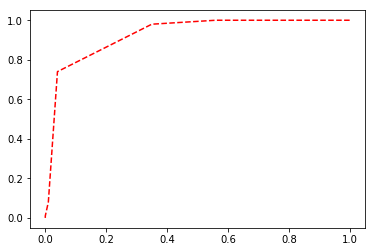

Text(0.5, 1.0, 'cov-NonFace')

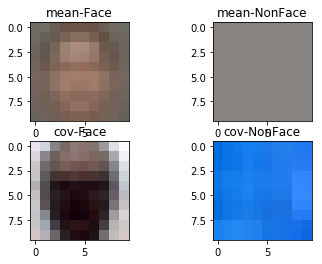

In [13]:
from scipy import special
from scipy.optimize import fsolve
import math

def EM_T(Input_data,v_start=3):
    trans=Input_data
    (N,D)=trans.shape
    #initialize
    u_start=np.mean(trans,axis=0)
    sigma_start=np.cov(trans.transpose())
 
    u_current=u_start
    sigma_current=sigma_start
    v_current=v_start
    for i in range(30):
        #E step
        temp_center_current=trans-u_current
        temp=v_current+np.sum(np.multiply(np.dot(temp_center_current,np.linalg.inv(sigma_current)),temp_center_current),axis=1)
        Exp_h=(v_current+D)/temp#N
        Exp_log_h=special.digamma((v_current+D)/2)-np.log(temp/2)
        
        #M step
        u_next=np.sum(np.multiply(trans.transpose(),Exp_h),axis=1)/np.sum(Exp_h)#D
        temp_center_current=trans-u_next#N*D
        sigma_next=np.dot(np.multiply(temp_center_current.transpose(),Exp_h),temp_center_current)/N
        def f(v):
            return(np.log(v/2)+1-special.digamma(v/2)+np.mean(Exp_log_h-Exp_h))
        v_next=fsolve(f,v_current)
        #check convergence
        delta_u=np.linalg.norm(u_current-u_next)/np.linalg.norm(u_current)
        delta_sigma=np.linalg.norm(sigma_current-sigma_next)/np.linalg.norm(sigma_current)
        delta_v=np.linalg.norm(v_next-v_current)/np.linalg.norm(v_current)
        #print(delta_u)
        #print(delta_sigma)
        #print(delta_v)
        #updatea
        u_current=u_next
        sigma_current=sigma_next
        v_current=v_next

    u=u_current
    sigma=sigma_current
    v=v_current
    return([u,sigma,v])
    


def Log_p_T(Input_data_orig,Face=True,v_start=3):
    (N,D)=Input_data_orig.shape
    if(Face==True):#for Face
        Input_data=Input_data_orig
        [u,sigma,v]=EM_T(Face_Train_images)
    else:#for Nonface
        Input_data=Input_data_orig
        [u,sigma,v]=EM_T(Nonface_Train_images)
        
    temp_center=Input_data-u
    log_p_t_dist=-(1/2)*np.sum(np.log(np.linalg.svd(sigma)[1]))-\
    (v+D)/2*np.log(1+(1/v)*np.sum(np.multiply(np.dot(temp_center,np.linalg.inv(sigma)),temp_center),axis=1))-\
    (D/2)*np.log(math.pi)-(D/2)*np.log(v)-np.log(special.gamma(v/2))+np.log(special.gamma((v+D)/2))
    return(log_p_t_dist)
        
    

def Label_T(Input_data_orig,v_start=3,threshold=0.5):
    delta=Log_p_T(Input_data_orig,Face=True,v_start=v_start)-Log_p_T(Input_data_orig,Face=False,v_start=v_start)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):
        estimated_label=np.zeros(Input_data_orig.shape[0])
        estimated_label[[i for i in range(Input_data_orig.shape[0]) if delta[i]>ratio_threshold]]=1
    return(estimated_label)
  

def FR_T(Input_data_orig,true_label,v_start=3,threshold=0.5):
    (N,D)=Input_data_orig.shape
    delta=Log_p_T(Input_data_orig,Face=True,v_start=v_start)-Log_p_T(Input_data_orig,Face=False,v_start=v_start)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):#threshold is a scalar
        #face_or_nonface
        estimated_label=np.zeros(N)
        estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
        #False Rate
        FR=np.zeros(3)
        FR[0]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
        FR[1]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        FR[2]=np.mean(np.abs(estimated_label-true_label))
        return(FR)
 

def ROC_T(Input_data_orig,true_label,ratio_threshold_seq,v_start=3):  
    N=Input_data_orig.shape[0]
    delta=Log_p_T(Input_data_orig,Face=True,v_start=v_start)-Log_p_T(Input_data_orig,Face=False,v_start=v_start)#log_p_face-log_p_nonface
    #ratio_threshold_seq=np.log(threshold_seq/(1-threshold_seq))
    if(isinstance(ratio_threshold_seq,np.ndarray)):#threshold is a seq
        FR=np.zeros((2,len(ratio_threshold_seq)))
        for i in range(len(ratio_threshold_seq)):
            #face_or_nonface
            ratio_threshold=ratio_threshold_seq[i]
            estimated_label=np.zeros(N)
            estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
            #False Rate
            FR[0,i]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
            FR[1,i]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        plt.plot(FR[0,:],1-FR[1,:],"r--")
        plt.show()             
 
#Evaluate the learned model on the testing images
Test_true_label=np.zeros(200)
Test_true_label[0:100]=1 
Train_true_label=np.zeros(2000)
Train_true_label[0:1000]=1 

print(FR_T(Train_images,true_label=Train_true_label,threshold=0.5,v_start=5))
print(FR_T(Test_images,true_label=Test_true_label,threshold=0.5,v_start=5))
ROC_T(Test_images,true_label=Test_true_label,ratio_threshold_seq=np.arange(-1500,1500,100),v_start=5)

#mean
[Face_u,Face_sigma,Face_v]=EM_T(Face_Train_images,v_start=3)
[Nonface_u,Nonface_sigma,Nonface_v]=EM_T(Nonface_Train_images,v_start=3)

plt.subplot(2, 2, 1)
plt.imshow(Face_u.reshape((10,10,3)).astype(int))
plt.title("mean-Face")

plt.subplot(2, 2, 2)
plt.imshow(Nonface_u.reshape((10,10,3)).astype(int))
plt.title("mean-NonFace")

#cov
plt.subplot(2, 2, 3)
cov_diag=np.diag(Face_sigma)    
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-Face")

plt.subplot(2, 2, 4)
cov_diag=np.diag(Nonface_sigma)  
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-NonFace")

Model 4: Factor Analysis

[0.356  0.163  0.2595]
[0.37  0.16  0.265]


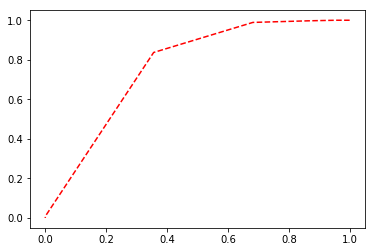

Text(0.5, 1.0, 'cov-NonFace')

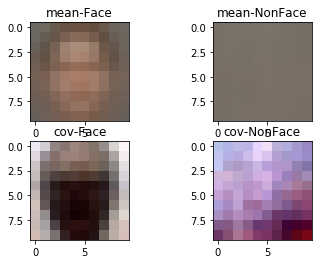

In [12]:
def EM_Factor(Input_data,K_sub=3):#K_sub: number of subspace
    trans=Input_data
    (N,D)=trans.shape
    #Initialize
    u=np.mean(trans,axis=0)
    Input_data=Face_Train_images
    sigma_full=np.cov(Face_Train_images.transpose())
    [U_matrix,D_matrix,V_matrix]=np.linalg.svd(sigma_full)
    eta_start=np.multiply(np.sqrt(D_matrix[0:K_sub]),U_matrix[:,0:K_sub])#
    sigma_start=np.diag(np.diag(sigma_full)-np.diag(np.dot(eta_start,eta_start.transpose())))
    
    sigma_current=sigma_start
    eta_current=eta_start
    
    Exp_hh=np.zeros((N,K_sub,K_sub))
    sum_Exp_hh=np.zeros((K_sub,K_sub))
    
    for t in range(60):
        #E
        sigma_current_inv=np.linalg.pinv(sigma_current)
        a=np.dot(np.dot(eta_current.transpose(),sigma_current_inv),eta_current)
        b=np.linalg.pinv(a+np.identity(K_sub))
        d=trans-u
        Exp_h=np.dot(np.dot(np.dot(b,eta_current.transpose()),sigma_current_inv),d.transpose()).transpose()#N*K
 
        for i in range(N):
            Exp_hh[i,:,:]= np.outer(Exp_h[i,:],Exp_h[i,:])+b
            sum_Exp_hh=sum_Exp_hh+Exp_hh[i,:,:]
        #M
        e=np.dot(Exp_h.transpose(),d)#K*D
       
        eta_next=np.dot(e.transpose(),np.linalg.pinv(sum_Exp_hh))#D*K
        sigma_next=np.diag(np.diag(np.dot(d.transpose(),d))-np.diag(np.dot(eta_next,e)))/N#D*D
        
        #check convergence
        delta_eta=np.linalg.norm(eta_next-eta_current)/np.linalg.norm(eta_current)
        delta_sigma=np.linalg.norm(sigma_next-sigma_current)/np.linalg.norm(sigma_current)
        #print(delta_eta)
        #print(delta_sigma)
        #update
        eta_current=eta_next
        sigma_current=sigma_next
        
    eta=eta_current
    sigma=sigma_current
    
    return([u,eta,sigma])

  
def Log_p_Factor(Input_data_orig,Face=True,K_sub=3):
    if(Face==True):#for Face
        Input_data=Input_data_orig
        [u,eta,sigma]=EM_Factor(Face_Train_images,K_sub=K_sub)
    else:#for Nonface
        Input_data=Input_data_orig
        [u,eta,sigma]=EM_Factor(Nonface_Train_images,K_sub=K_sub)
        
    temp_1=np.dot(eta,eta.transpose())+sigma
    temp_2=Input_data-u
    log_p=-(1/2)*np.sum(np.log(np.linalg.svd(temp_1)[1]))-(1/2)*np.sum(np.multiply(np.dot(temp_2,np.linalg.pinv(temp_1)),temp_2),axis=1)
    return(log_p)
    
def Label_Factor(Input_data_orig,K_sub=3,threshold=0.5):
    delta=Log_p_Factor(Input_data_orig,Face=True,K_sub=K_sub)-Log_p_Factor(Input_data_orig,Face=False,K_sub=K_sub)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    
    if(isinstance(threshold,np.ndarray)==False):
        estimated_label=np.zeros(Input_data_orig.shape[0])
        estimated_label[[i for i in range(Input_data_orig.shape[0]) if delta[i]>ratio_threshold]]=1
    return(estimated_label)
    
#FR
def FR_Factor(Input_data_orig,true_label,K_sub=3,threshold=0.5):
    N=Input_data_orig.shape[0]
    delta=Log_p_Factor(Input_data_orig,Face=True,K_sub=K_sub)-Log_p_Factor(Input_data_orig,Face=False,K_sub=K_sub)#log_p_face-log_p_nonface
    ratio_threshold=np.log(threshold/(1-threshold))
    if(isinstance(threshold,np.ndarray)==False):#threshold is a scalar
        #face_or_nonface
        estimated_label=np.zeros(N)
        estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
        #False Rate
        FR=np.zeros(3)
        FR[0]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
        FR[1]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        FR[2]=np.mean(np.abs(estimated_label-true_label))
        return(FR)

#ROC curve
def ROC_Factor(Input_data_orig,true_label,ratio_threshold_seq,K_sub=3):
    N=Input_data_orig.shape[0]
    delta=Log_p_Factor(Input_data_orig,Face=True,K_sub=K_sub)-Log_p_Factor(Input_data_orig,Face=False,K_sub=K_sub)#log_p_face-log_p_nonface
    if(isinstance(ratio_threshold_seq,np.ndarray)):#threshold is a seq
        FR=np.zeros((2,len(ratio_threshold_seq)))
        for i in range(len(ratio_threshold_seq)):
            #face_or_nonface
            ratio_threshold=ratio_threshold_seq[i]
            estimated_label=np.zeros(N)
            estimated_label[[i for i in range(N) if delta[i]>ratio_threshold]]=1
            #False Rate
            FR[0,i]=np.mean(estimated_label[[i for i in range(N) if true_label[i]==0]])
            FR[1,i]=1-np.mean(estimated_label[[i for i in range(N) if true_label[i]==1]])
        plt.plot(FR[0,:],1-FR[1,:],"r--")
        plt.show()
        
#Evaluate the learned model on the testing images
Test_true_label=np.zeros(200)
Test_true_label[0:100]=1   
Train_true_label=np.zeros(2000)
Train_true_label[0:1000]=1 


print(FR_Factor(Train_images,true_label=Train_true_label,threshold=0.5,K_sub=3))
print(FR_Factor(Test_images,true_label=Test_true_label,threshold=0.5,K_sub=3))
ROC_Factor(Train_images,true_label=Train_true_label,ratio_threshold_seq=np.arange(-1500,1500,100),K_sub=3)


[Face_u,Face_eta,Face_sigma]=EM_Factor(Face_Train_images,3)
[Nonface_u,Nonface_eta,Nonface_sigma]=EM_Factor(Nonface_Train_images,3)

#mean
plt.subplot(2, 2, 1)
plt.imshow(Face_u.reshape((10,10,3)).astype(int))
plt.title("mean-Face")

plt.subplot(2, 2, 2)
plt.imshow(Nonface_u.reshape((10,10,3)).astype(int))
plt.title("mean-NonFace")

#cov
plt.subplot(2, 2, 3)
cov_diag=np.diag(np.dot(Face_eta,Face_eta.transpose())+Face_sigma)    
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-Face")

plt.subplot(2, 2, 4)
cov_diag=np.diag(np.dot(Nonface_eta,Nonface_eta.transpose())+Nonface_sigma) 
[min_v,max_v]=[np.min(cov_diag),np.max(cov_diag)]
norm_cov_diag=(cov_diag-min_v)/(max_v-min_v)*255
plt.imshow(norm_cov_diag.reshape((10,10,3)).astype(int))
plt.title("cov-NonFace")

False Rate

In [14]:
#single gaussian
print(FR_Gaussian(Test_images,true_label=Test_true_label,threshold=0.5))

#mix of gaussian 
print(FR_Mix_Gaussian(Test_images,Test_true_label,K=6,threshold=0.5))

#t distribution
print(FR_T(Test_images,true_label=Test_true_label,threshold=0.5,v_start=5))

#factor analysis
print(FR_Factor(Test_images,true_label=Test_true_label,threshold=0.5,K_sub=3))



[0.31 0.01 0.16]
[0.19  0.12  0.155]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


[0.35  0.02  0.185]
[0.37  0.16  0.265]
